# MODIS Water Histogram-based Gradient Boosting Classification Tree

Version: 0.1.0

Date modified: 04.21.2022

Modified by: Caleb Spradlin

In [3]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
import optuna

from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
FIGURE_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

qaMaskPath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/adapt/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
TILE = 'Golden'
MODEL = 'HGBM'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = ['sur_refl_b05_1']#'sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [5]:
colsToDrop

['sur_refl_b05_1']

In [6]:
colsToDropTraining

['sur_refl_b05_1', 'x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

In [7]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print('Imbalancing data, sampling {} from land'.format(frac))
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [8]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])
data_path = data_paths[0]
pprint(data_paths)
print(data_path)

['/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip']
/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip


In [9]:
X_bg, y_bg = load_data(fpath=data_path,
                       colsToDrop=colsToDropTraining,
                       dataType=DATA_TYPE,
                       cpu=True,
                       splitXY=True,
                       imbalance=False,
                       trainTestSplit=False)

In [10]:
model_path = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.978_HGBM_100_4.1.0_tuned_cpu.sav'

In [11]:
classifier = joblib.load(model_path)

# Testing: raster testing

In [23]:
import math

Good test days:

| Tile           | Year       | Day   |
|:---------------|:-----------|:------|
| h11v10         | 2006       | 201   |
| h18v03         | 2020       | 177   |
| h09v09         | 2001       | 268   |
| h11v02         | 2001       | 228   |

In [1]:
TILE = 'h18v03'
DAY = 177
YEAR = 2020

In [325]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

def get_data_predict(PATH, TILE, YEAR, DAY, classifier):
    vars_list_gq = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
                if 'sur_refl' in fn and 'GQ' in fn]
    vars_list_gq.sort()

    vars_list_ga = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
                if 'sur_refl' in fn and 'GQ' not in fn]
    vars_list_ga.sort()

    vars_list = vars_list_gq
    vars_list.extend(vars_list_ga)
    print(vars_list)
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    dd = None
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt') 
    im = readRasterToArray(vars_list)
    print('Raster as ndarray')
    print(im)
    print('{} MB size'.format((im.size * im.itemsize) / 1000000))
    predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)
    shp = (4800, 4800)
    left = list()
    right = list()
    for i, subarr in enumerate(predictedProbaRaster):
        left.append(subarr[0])
        right.append(subarr[1])
    leftArr = np.asarray(left)
    rightArr = np.asarray(right)
    probaLand = leftArr.reshape(shp)
    probaWater = rightArr.reshape(shp)
    matrix = np.asarray(predictedRaster)
    reshp = matrix.reshape(shp)
    qa_list = [fn for fn in glob.glob(os.path.join(qaMaskPath, '{}/*A{}{:03}.{}*.tif'.format(TILE, YEAR, DAY, TILE)))]
    try:
        qa_mask = qa_list[0]
        print(qa_mask)
        ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
        qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
    except Exception:
        path = os.path.join(qaMaskPath, '{}/*A{}{:03}.{}*.tif'.format(TILE, YEAR, DAY, TILE))
        print('Could not find QA mask at {}'.format(path))
        qaMaskMatrix = np.zeros((4800, 4800))
    if YEAR == 2020:
        YEAR = 2019
    water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
    print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
    water_mask_path = water_list[0]
    print(water_mask_path)
    if YEAR == 2019:
        YEAR = 2020
    water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
    waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
    waterMask = None
    maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
    maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
    waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
    waterMaskRavel = waterMasked.ravel()
    imWater = (waterMaskRavel == 1)
    tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
    tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
    fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
    fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
    total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
    truePositives = np.count_nonzero(tp == 1)
    trueNegatives = np.count_nonzero(tn == 1)
    falsePositives = np.count_nonzero(fp == 1)
    falseNegatives = np.count_nonzero(fn == 1)
    accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
    jians = truePositives / (truePositives + trueNegatives)
    pc = truePositives / (truePositives + falsePositives)
    rc = truePositives / (truePositives + falseNegatives)
    f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
    mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
    mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
    mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)
    countNoData = np.count_nonzero(maskedResult == -9999)
    countLand = np.count_nonzero(maskedResult == 0)
    countWater = np.count_nonzero(maskedResult == 1)
    print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))
    countNoDataT = np.count_nonzero(waterMasked == -9999)
    countLandT = np.count_nonzero(waterMasked == 0)
    countWaterT = np.count_nonzero(waterMasked == 1)
    print('Min. extent water mask vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))
    print('Metrics of Accuracy for Raster Test Data')
    print('True Positives:  {}'.format(truePositives))
    print('True Negatives:  {}'.format(trueNegatives))
    print('False Positives: {}'.format(falsePositives))
    print('False Negatives: {}'.format(falseNegatives))
    print('Total "good" data: {}'.format(total))
    print('Precision: {}'.format(pc))
    print('Recall: {}'.format(rc))
    print('f1: {}'.format(f1))
    print('MCC: {}'.format(mcc))
    outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
    waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
    outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
    print(outPath)
    print(waterMaskForDay)
    print(outPathProba)

    ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    ncols = ds.RasterXSize
    nrows = ds.RasterYSize
    ds = None

    # Output predicted binary raster masked with good-bad mask.
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
    outDs.SetGeoTransform(geo)
    outDs.SetProjection(proj)
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(maskedResult)
    outBand.SetNoDataValue(-9999)
    outDs.FlushCache()
    outDs = None
    outBand = None
    driver = None

    # Output water mask with good-bad masked.
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
    outDs.SetGeoTransform(geo)
    outDs.SetProjection(proj)
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(waterMasked)
    outBand.SetNoDataValue(-9999)
    outDs.FlushCache()
    outDs = None
    outBand = None
    driver = None

    # Output probabilies raster masked by good-bad mask.
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
    outDs.SetGeoTransform(geo)
    outDs.SetProjection(proj)
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(maskedResultProba)
    outBand.SetNoDataValue(-9999)
    outDs.FlushCache()
    outDs = None
    outBand = None
    driver = None
    outputDict = {}
    outputDict['outPath'] = outPath
    outputDict['outPathProba'] = outPath
    outputDict['water_mask_path'] = water_mask_path
    outputDict['qa_mask'] = qa_mask
    outputDict['maskedResult'] = maskedResult
    outputDict['waterMasked'] = waterMasked
    outputDict['vars_list'] = vars_list
    
    return outputDict

In [326]:
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [327]:
outputDict = get_data_predict(PATH, TILE, YEAR, DAY, classifier)

['/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GQ.A2006201.h11v10.061.2020266164349-sur_refl_b01_1.tif', '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GQ.A2006201.h11v10.061.2020266164349-sur_refl_b02_1.tif', '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b03_1.tif', '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b04_1.tif', '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b05_1.tif', '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b06_1.tif', '/adapt/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/h11v10/MOD09GA.A2006201.h11v10.061.2020266164349-sur_refl_b07_1.tif']
Raster as ndarray
[[ 282 2985  173 ... 8

## Folium Viewing

In [328]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [329]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} does not exist.'.format(filename))

In [330]:
mask_3857 = reproject_to_3857(outputDict['outPath'])
probW_3857 = reproject_to_3857(outputDict['outPathProba'])
mod44_3857 = reproject_to_3857(outputDict['water_mask_path'])
qa_3857 = reproject_to_3857(outputDict['qa_mask'])

mask_d = get_bounds(mask_3857)
probw_d = get_bounds(probW_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
probw_b1 = open_and_get_band(probW_3857, 1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(probW_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
probw_rgb = np.dstack((zeros, zeros, probw_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
No file: /tmp/2006_201_h11v10_predicted_HGBM-3857.tif does not exist.


In [331]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [332]:
from folium import plugins

In [333]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(probw_rgb, probw_d, '{}-{}-{} model proba water'.format(YEAR, DAY, TILE), opacity=0.35, show=False))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())

## Model prediction explainability

In [334]:
from matplotlib.patches import Rectangle

In [335]:
maskedResult = outputDict['maskedResult']
waterMasked = outputDict['waterMasked']
maskToShow = np.where(maskedResult==-9999, -1, maskedResult)
waterMaskToShow = np.where(waterMasked==-9999, -1, waterMasked)

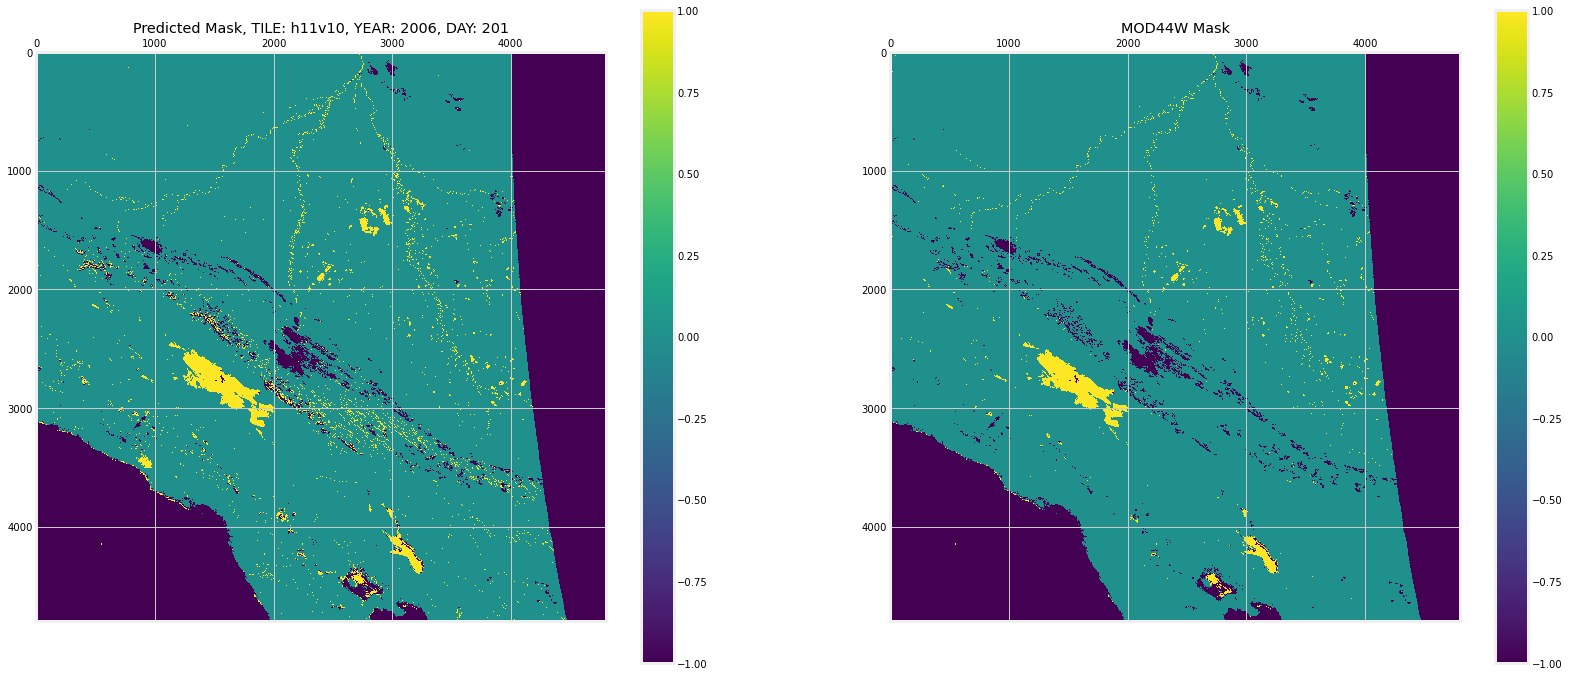

In [336]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

ax1, ax2 = axes

im1 = ax1.matshow(maskToShow)
im2 = ax2.matshow(waterMaskToShow)

ax1.set_title('Predicted Mask, TILE: {}, YEAR: {}, DAY: {}'.format(TILE, YEAR, DAY))
ax2.set_title('MOD44W Mask')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [359]:
y = (3000, 3000+250)
x = (2500, 2500+230)
width = x[1] - x[0]
height = y[1] - y[0]

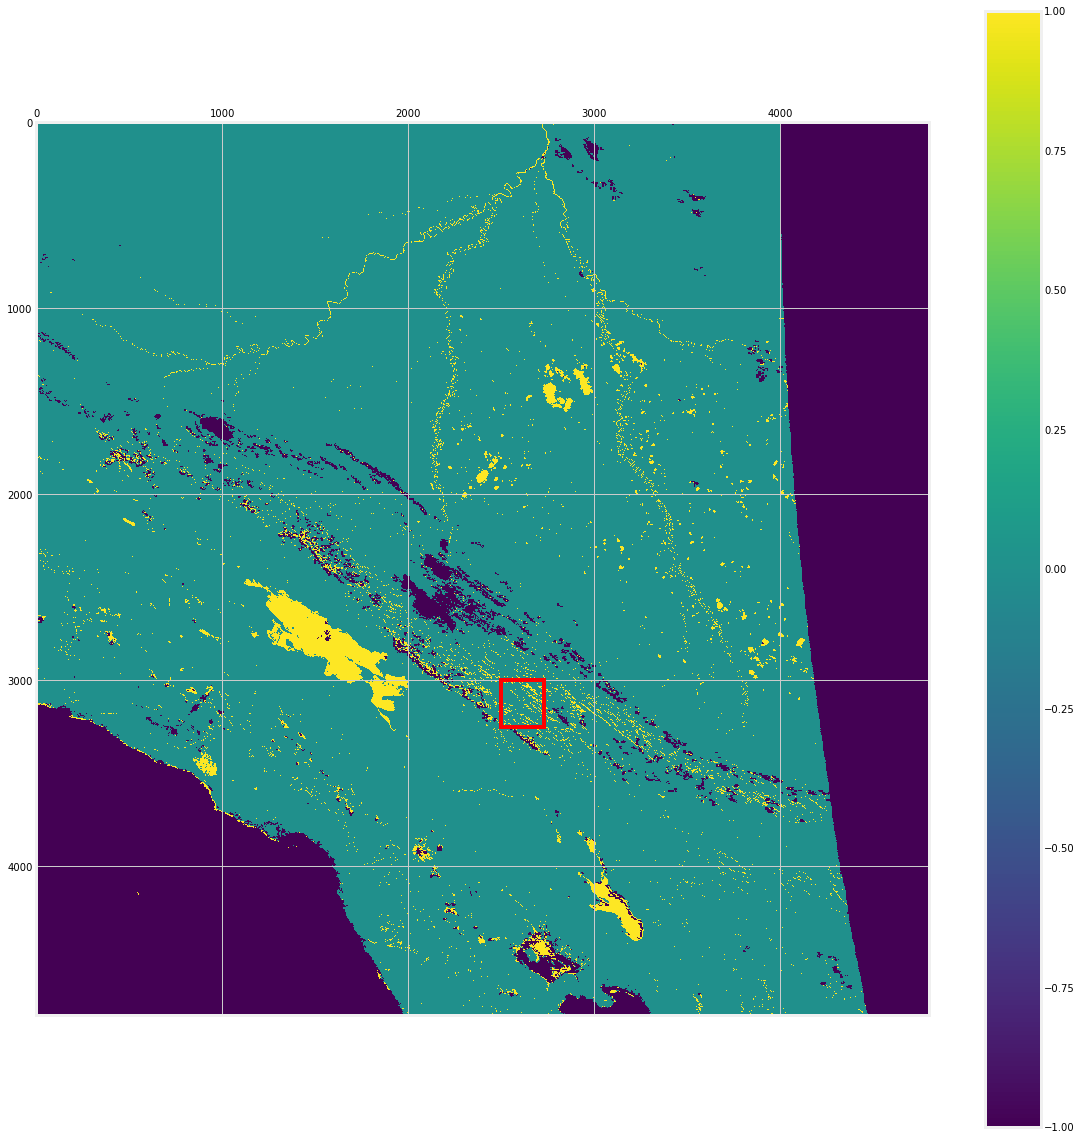

In [360]:
plt.figure(figsize=(20, 20))
plt.matshow(maskToShow, fignum=1)
plt.gca().add_patch(Rectangle((x[0],y[0]),width,height,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
plt.colorbar()

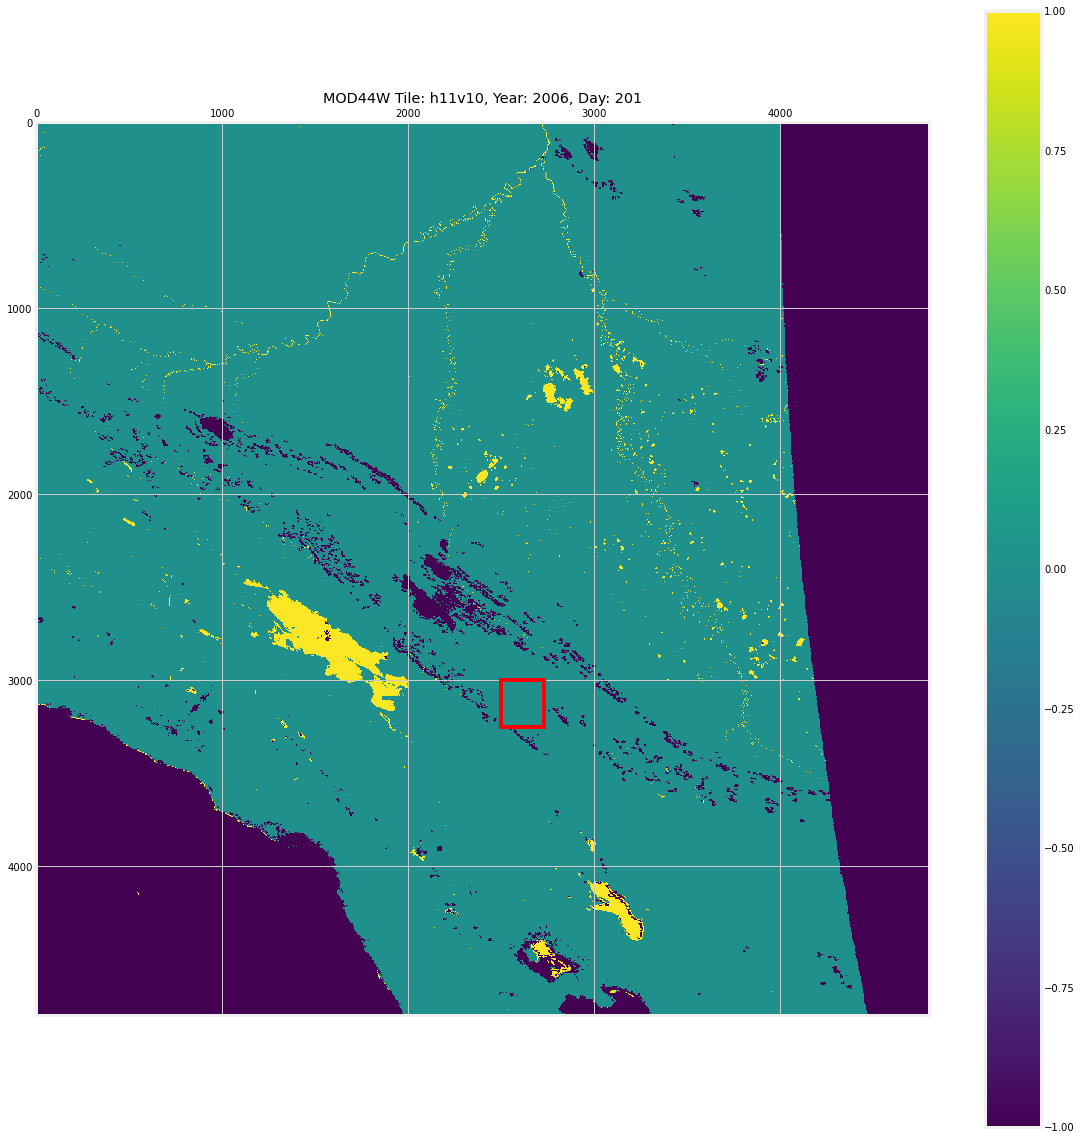

In [361]:
plt.figure(figsize=(20, 20))
plt.matshow(waterMaskToShow, fignum=1)
plt.gca().add_patch(Rectangle((x[0],y[0]),width,height,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
plt.title('MOD44W Tile: {}, Year: {}, Day: {}'.format(TILE, YEAR, DAY))
plt.colorbar()

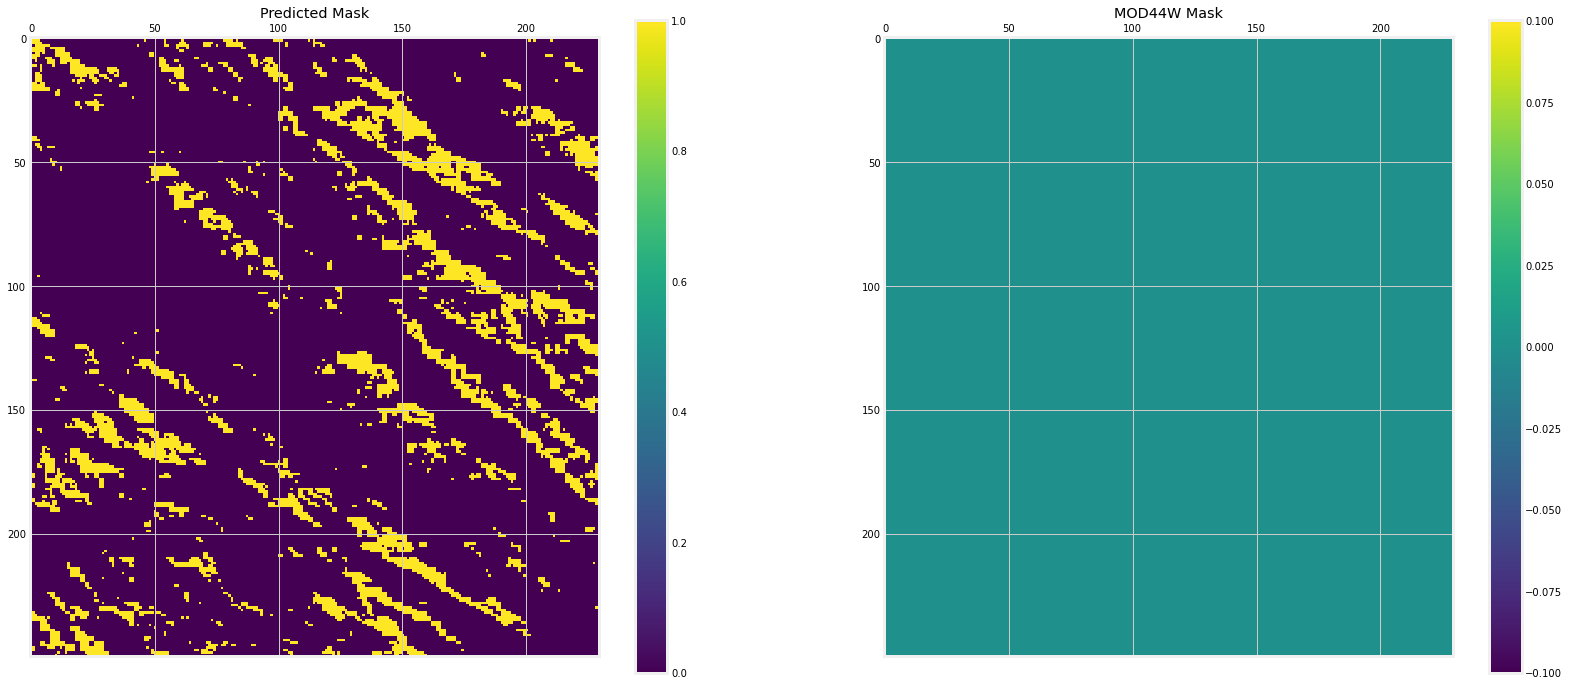

In [362]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

ax1, ax2 = axes

im1 = ax1.matshow(maskToShow[y[0]:y[1], x[0]:x[1]])
im2 = ax2.matshow(waterMaskToShow[y[0]:y[1], x[0]:x[1]])

ax1.set_title('Predicted Mask')
ax2.set_title('MOD44W Mask')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [363]:
def readRaster(vars_list, x, y, colsToDrop=None):
    min_right, max_right = x
    min_bottom, max_bottom = y
    cols = max_bottom - min_bottom
    rows = max_right - min_right
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (cols, rows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, :, b] = dd.GetRasterBand(b+1).ReadAsArray()[min_bottom:max_bottom, min_right:max_right].astype(np.int16)
    dd = None
    img[:, :, len(vars_list)] = ((img[:,:,1] - img[:,:,0]) / (img[:,:,1] + img[:,:,0])) * 10000
    img[:, :, len(vars_list)+1] = ((img[:,:,1] - img[:,:,5]) / (img[:,:,1] + img[:,:,5])) * 10000
    img[:, :, len(vars_list)+2] = ((img[:,:,1] - img[:,:,6]) / (img[:,:,1] + img[:,:,6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

def plot_comparison(mask, band, img):
    fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

    ax1, ax2 = axes

    im1 = ax1.matshow(img[:, :, band-1])
    im2 = ax2.matshow(mask)
    band_name = band
    if band >=8 :
        if band == 8:
            band_name = 'ndvi'
        elif band == 9:
            band_name = 'ndwi1'
        elif band == 10:
            band_name = 'ndwi2'
            
    ax1.set_title('Tile: {} Day: {} Year: {} Band: {}'.format(TILE, DAY, YEAR, band_name))
    ax2.set_title('Tile: {} Day: {} Year: {} Predicted Water Mask'.format(TILE, DAY, YEAR))
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)
    
def readRasterToArray(vars_list, x, y, colsToDrop=None):
    min_right, max_right = x
    min_bottom, max_bottom = y
    cols = max_bottom - min_bottom
    rows = max_right - min_right
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (cols*rows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray()[min_bottom:max_bottom, min_right:max_right].astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    df = pd.DataFrame(img, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    return df

def get_idx(idx, shape):
    idx_unr = np.unravel_index((idx,), shape)
    print(idx_unr)
    idx_unr = (idx_unr[0][0], idx_unr[1][0])
    return idx_unr

def plot_comparison_explain(mask, band, img, idx):
    y, x = get_idx(idx, shape=mask.shape)
    y = (y-5, y+5)
    x = (x-5, x+5)
    width = x[1]-x[0]
    height = y[1]-y[0]
    fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

    ax1, ax2 = axes

    im1 = ax1.matshow(img[:, :, band-1])
    im2 = ax2.matshow(mask)
    shap.force_plot(explainer.expected_value[1], 
                    shap_test[:, :, 1].values[idx], 
                    feature_names=shap_test.feature_names, 
                    matplotlib=True, 
                    show=False)
    band_name = band
    if band >=8 :
        if band == 8:
            band_name = 'ndvi'
        elif band == 9:
            band_name = 'ndwi1'
        elif band == 10:
            band_name = 'ndwi2'
    ax1.add_patch(Rectangle((x[0],y[0]),width,height,
                        edgecolor='red',
                        facecolor='none',
                        lw=4))
    ax2.add_patch(Rectangle((x[0],y[0]),width,height,
                        edgecolor='red',
                        facecolor='none',
                        lw=4))
    ax1.set_title('Tile: {} Day: {} Year: {} Band: {}'.format(TILE, DAY, YEAR, band_name))
    ax2.set_title('Tile: {} Day: {} Year: {} Predicted Water Mask'.format(TILE, DAY, YEAR))
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

def findFP(x, y, mask, waterMask, df, n=20):
    indexIDList = [i for i in range(n)]
    y_preds = mask.ravel()
    y_mod44 = waterMask[y[0]:y[1], x[0]:x[1]].ravel()
    X_withPreds = df.assign(predicted=y_preds)
    X_withPreds = X_withPreds.assign(MOD44=y_mod44)
    predictedWater = X_withPreds[X_withPreds['predicted'] == 1]
    falsePositives = predictedWater[predictedWater['MOD44'] == 0]
    falsePositives = falsePositives.sample(frac=1)
    falsePositives = falsePositives.sample(n=n)
    falsePositives = falsePositives.assign(indexID=indexIDList)
    return falsePositives

In [364]:
img = readRaster(outputDict['vars_list'], x, y, colsToDrop=colsToDrop)

Band key:

- 1 = sur_refl_b01
- 2 = sur_refl_b02
- 3 = sur_refl_b03
- 4 = sur_refl_b04
- 5 = sur_refl_b05
- 6 = sur_refl_b06
- 7 = sur_refl_b07
- 8 = ndvi
- 9 = ndwi1
- 10 = ndwi2

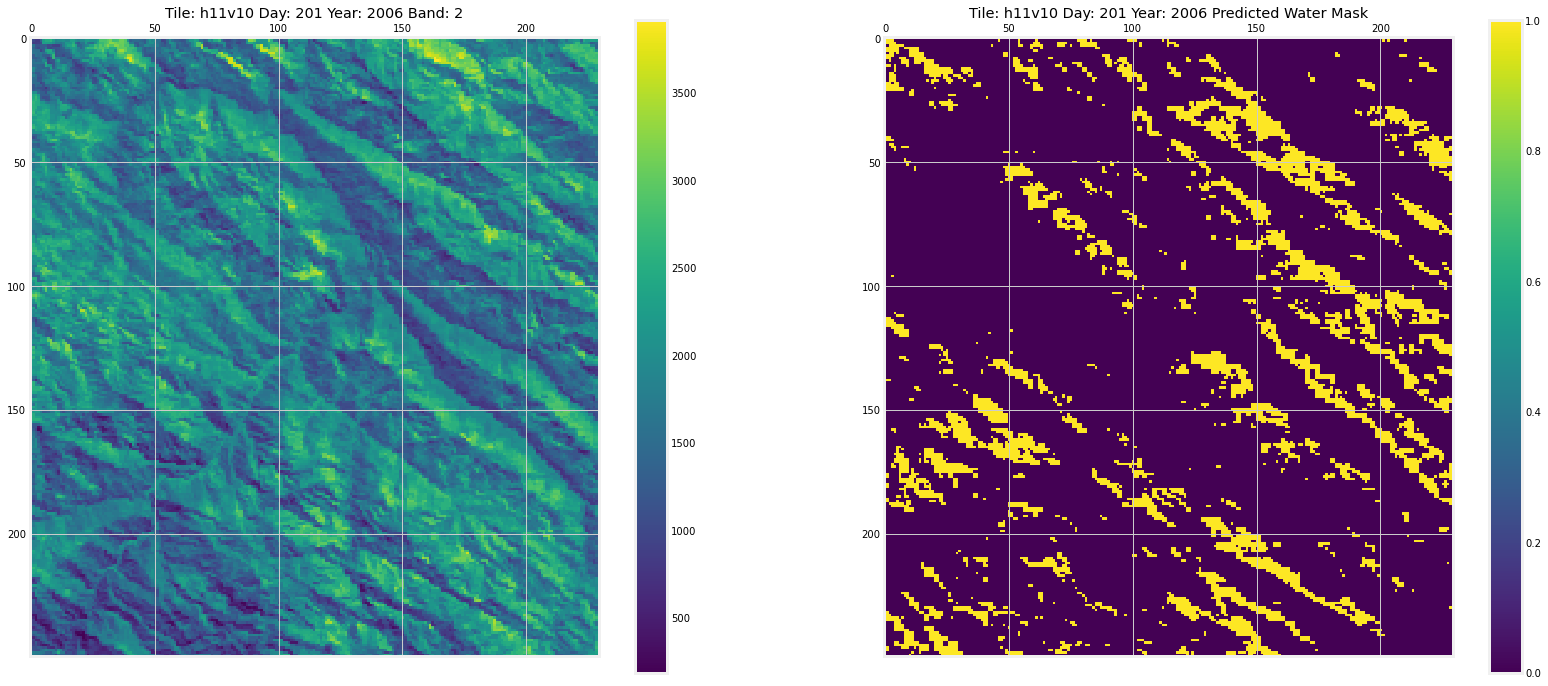

In [365]:
mask = maskToShow[y[0]:y[1], x[0]:x[1]]
plot_comparison(mask=mask,
                band=2,
                img=img)

In [366]:
X_expl = readRasterToArray(outputDict['vars_list'], x, y, colsToDrop)
X_expl

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,104,1154,50,142,695,247,8346,2482,6473
1,129,1358,50,142,695,247,8264,3229,6922
2,152,1825,50,142,695,247,8462,4484,7615
3,241,2410,50,142,695,247,8181,5523,8140
4,241,2410,96,233,1053,426,8181,3918,6995
...,...,...,...,...,...,...,...,...,...
57495,351,2270,294,499,2001,1185,7321,629,3140
57496,367,2338,240,440,1686,762,7286,1620,5083
57497,293,2291,240,440,1686,762,7732,1521,5008
57498,264,2195,205,414,1672,742,7852,1352,4947


In [367]:
try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    import shap

In [368]:
shap.initjs()

In [369]:
bg_set = X_bg.sample(n=500)
bg_set = bg_set.reset_index()
bg_set = bg_set.drop(columns=['index'])

In [370]:
explainer = shap.explainers.Tree(model=classifier, data=bg_set, model_output='predict_proba')
shap_test = explainer(X_expl)
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test:\n{shap_test[0]}")

100%|===================| 57462/57500 [03:07<00:00]        

Length of shap_test: 57500

Sample shap_test:
.values =
array([[-0.03441479,  0.03441479],
       [-0.08589441,  0.08589441],
       [-0.07231151,  0.07231151],
       [ 0.03780518, -0.03780518],
       [-0.15942002,  0.15942002],
       [-0.03922547,  0.03922547],
       [ 0.09669713, -0.09669713],
       [-0.00605535,  0.00605535],
       [ 0.00968387, -0.00968387]])

.base_values =
array([0.63666394, 0.36333606])

.data =
array([ 104, 1154,   50,  142,  695,  247, 8346, 2482, 6473], dtype=int16)


In [371]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_bg.mean():.2f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.2f}")

Expected value: 0.36
Average target value (training data): 0.43
Base value: 0.36


In [372]:
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
                       columns=shap_test.feature_names, 
                       index=X_expl.index)
shap_df

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,0.034415,0.085894,0.072312,-0.037805,0.159420,0.039225,-0.096697,0.006055,-0.009684
1,0.037901,0.018727,0.059102,-0.032102,0.148798,0.031578,-0.106792,0.006459,-0.009205
2,0.012984,-0.079693,0.029952,-0.037661,0.095089,0.016238,-0.137396,0.015699,-0.008371
3,0.023021,-0.115743,0.017557,-0.054918,0.093655,-0.001764,-0.111455,0.019713,-0.017817
4,0.003520,-0.105275,-0.006897,-0.031318,-0.039312,-0.022704,-0.135065,-0.002303,-0.010822
...,...,...,...,...,...,...,...,...,...
57495,-0.007519,-0.071305,0.000409,-0.033908,-0.060830,-0.039710,-0.124437,-0.010839,-0.007366
57496,-0.004781,-0.083759,0.001930,-0.025166,-0.055463,-0.030664,-0.124441,-0.010764,-0.008518
57497,-0.004752,-0.084665,0.003315,-0.024713,-0.055504,-0.030166,-0.123910,-0.011354,-0.008975
57498,-0.001843,-0.084808,0.004253,-0.027080,-0.049180,-0.031248,-0.124130,-0.012033,-0.008722


In [373]:
np.isclose(classifier.predict_proba(X_expl)[:,1], 
           explainer.expected_value[1] + shap_df.sum(axis=1))

array([ True,  True,  True, ...,  True,  True,  True])

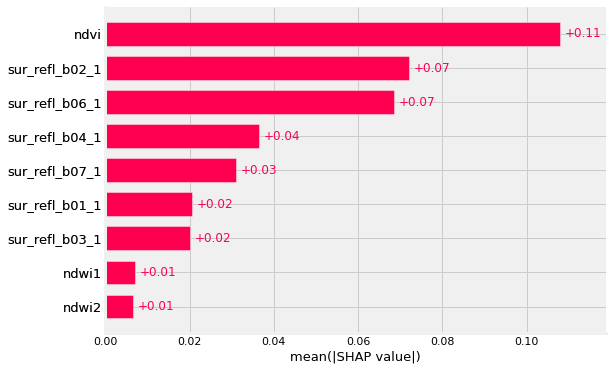

In [374]:
shap.plots.bar(shap_test[:,:,1])

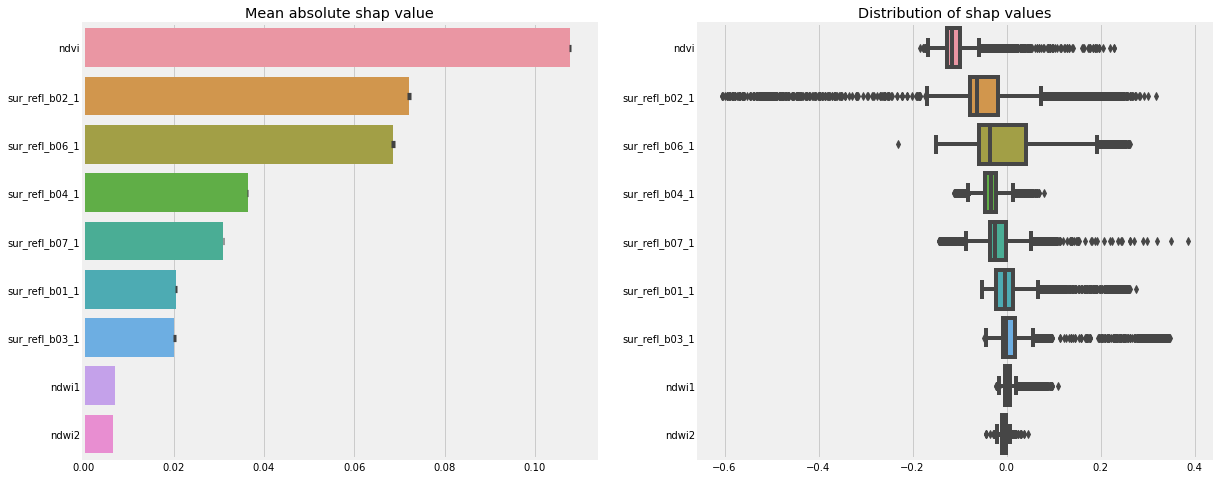

In [375]:
columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index

fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h',ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

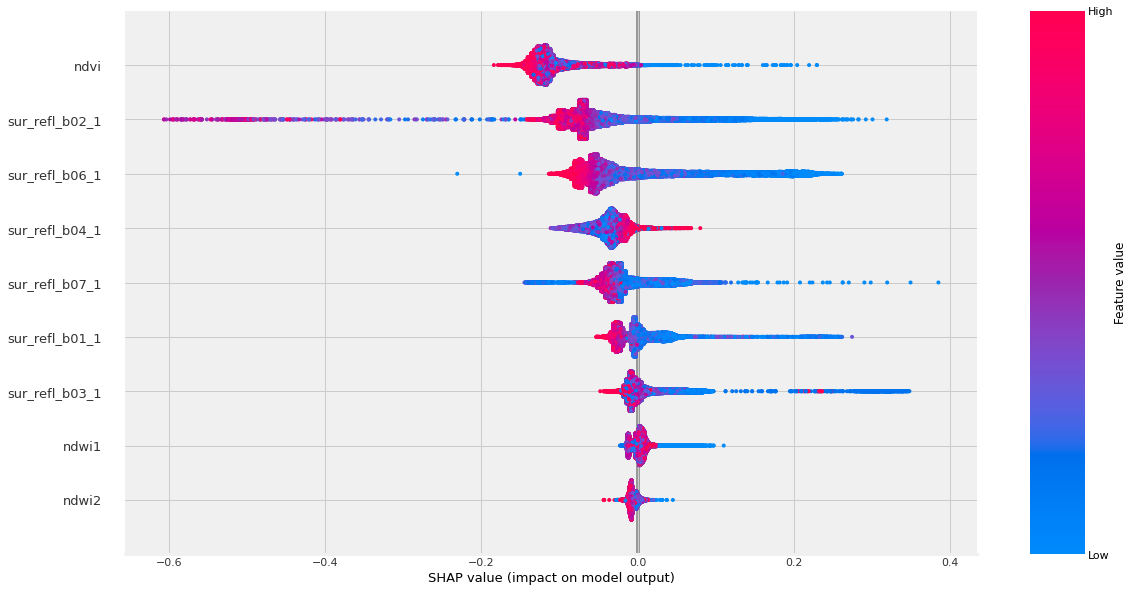

In [376]:
shap.summary_plot(shap_test[:,:,1], plot_size=(17, 10), show=False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)

In [377]:
falsePositives = findFP(x, y, mask=mask, waterMask=waterMaskToShow, df=X_expl, n=20)
falsePositives

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,predicted,MOD44,indexID
41133,137,1177,132,236,797,286,7914,1925,6090,1,0,0
38341,161,1112,136,256,777,272,7470,1773,6069,1,0,1
22727,159,1487,27,111,634,207,8068,4021,7556,1,0,2
43756,273,673,110,205,646,411,4228,204,2416,1,0,3
27820,144,802,44,138,599,223,6955,1448,5648,1,0,4
19023,181,1191,44,162,785,322,7361,2054,5743,1,0,5
46375,238,1312,72,172,692,289,6929,3093,6389,1,0,6
29841,286,1213,136,252,949,459,6184,1221,4509,1,0,7
13697,318,1021,224,336,1100,544,5250,-372,3047,1,0,8
27336,147,1191,71,167,614,194,7802,3196,7198,1,0,9


## Look through false positives

Using the dataframe above select by "indexID" which prediction we'd like to examine.

Band key:

- 1 = sur_refl_b01
- 2 = sur_refl_b02
- 3 = sur_refl_b03
- 4 = sur_refl_b04
- 5 = sur_refl_b05
- 6 = sur_refl_b06
- 7 = sur_refl_b07
- 8 = ndvi
- 9 = ndwi1
- 10 = ndwi2

In [381]:
band = 6
index = 0

(array([178]), array([193]))


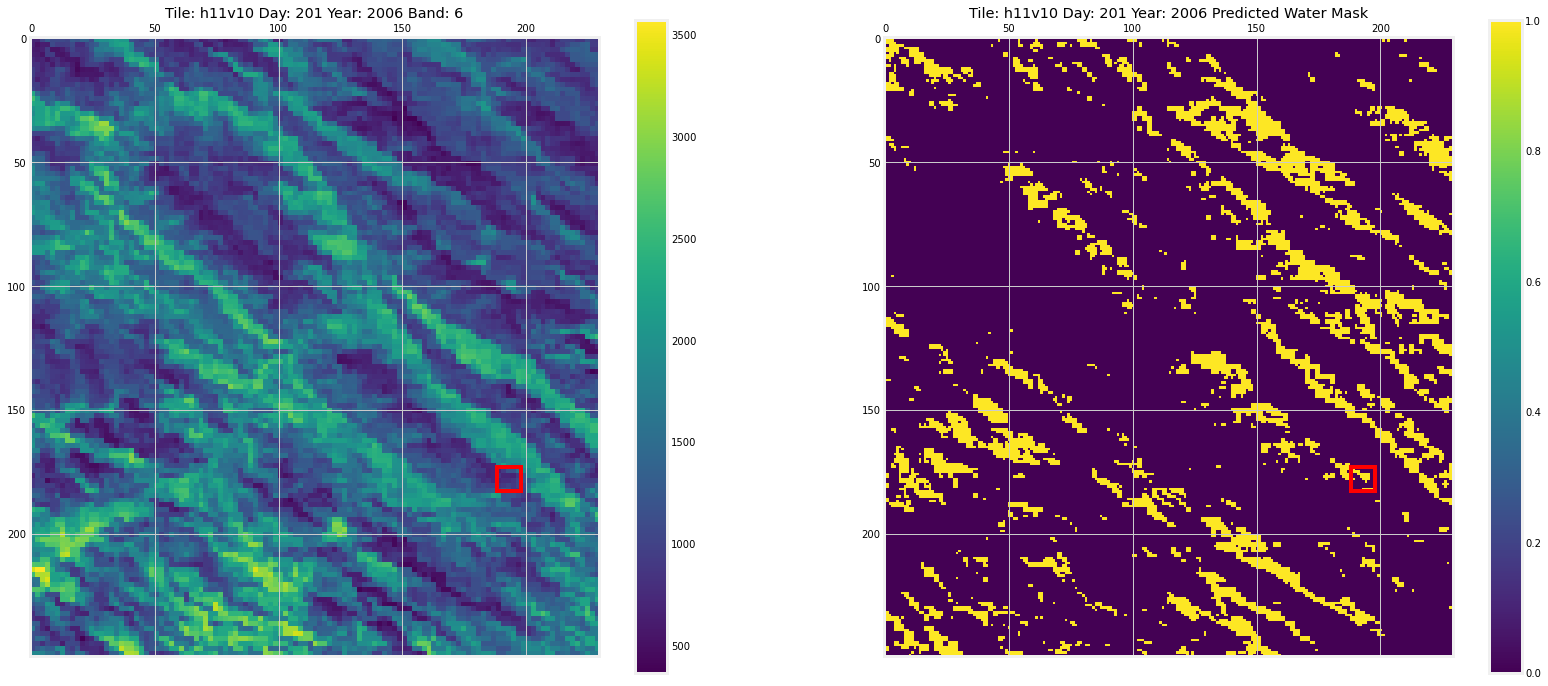

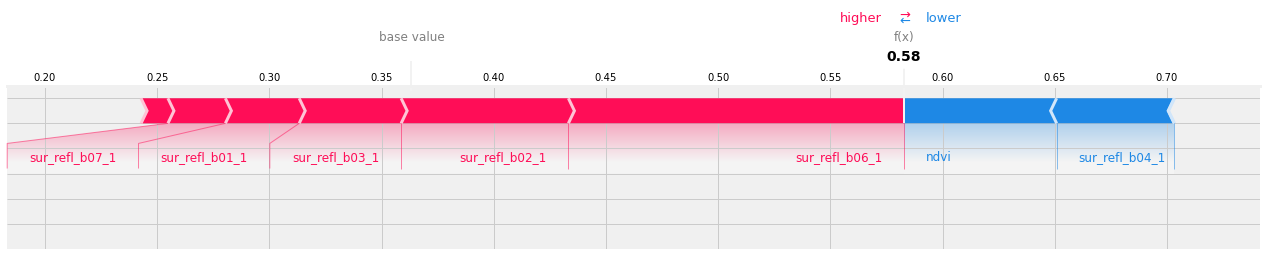

In [382]:
plot_comparison_explain(mask, band, img, idx=falsePositives.index[index])

In [380]:
pd.DataFrame(X_expl.iloc[falsePositives.index[index]]).T

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
41133,137,1177,132,236,797,286,7914,1925,6090
